In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dependencies 
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt 

In [ ]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Uncompress Tar GZ labelled file 
# http://vis-www.cs.umass.edu/lfw/#download 

%cd '/content/drive/My Drive/side_projects'
# !tar -xf lfw.tgz

/content/drive/My Drive/side_projects


In [ ]:
# images = tf.data.Dataset.list_files('//content//drive//My Drive//side_projects//lfw//*.jpg')


In [ ]:
# Setup paths 
pos_dir = os.path.join('data', 'positive')
neg_dir = os.path.join('data', 'negative')
anc_dir = os.path.join('data', 'anchor')

In [ ]:
# Make the directories 
# os.makedirs(pos_dir)
# os.makedirs(neg_dir)
# os.makedirs(anc_dir)

In [ ]:
# Move LFW images to data/negative
# for dir in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw',dir)):
#     ex_path = os.path.join('lfw',dir, file)
#     new_path = os.path.join(neg_dir, file)
#     os.replace(ex_path, new_path)


# 3. Load and Preprocess Images
## 3.1 Get Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(anc_dir+'/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(anc_dir+'/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(neg_dir+'/*.jpg').take(3000)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
dir_test.next()

b'data/anchor/photo_15.jpg'

## 3.2 Preprocessing - Scale and Resize


In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 (normalization)
    img = img / 255.0

    # Return image
    return img

0.94558823

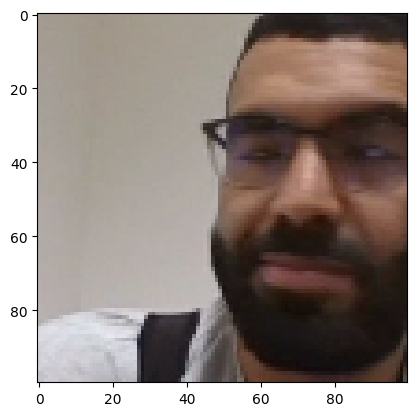

In [ ]:
img = preprocess('data/anchor/photo_23.jpg')
plt.imshow(img)
img.numpy().max() 

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data/anchor/an.jpg_6.jpg', b'data/anchor/ph_10.jpg', 1.0)

## 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)

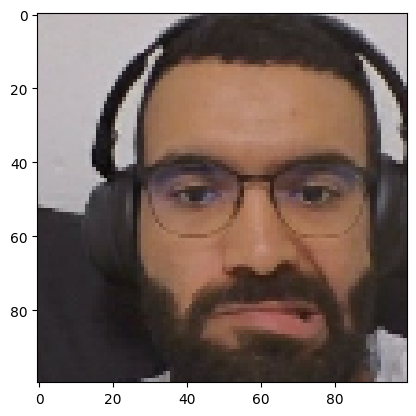

In [ ]:
plt.imshow(res[0])

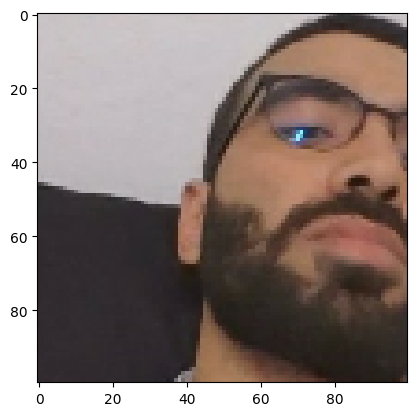

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]

1.0

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
one_sample = data.as_numpy_iterator()

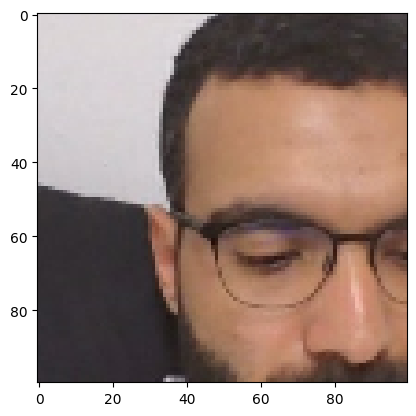

In [ ]:
sample = one_sample.next()
plt.imshow(sample[0])

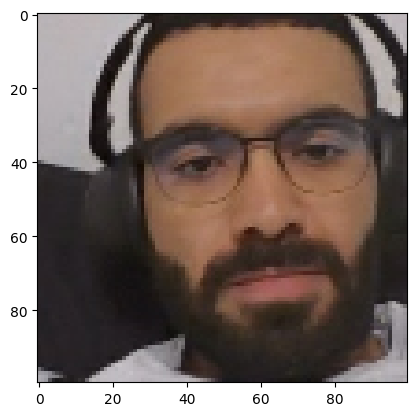

In [ ]:
plt.imshow(sample[1])

In [ ]:
sample[2]

1.0

# 4. Model Engineering
## 4.1 Build Embedding Layer

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer


In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()
# l1(anchor_embedding, validation_embedding)
l1

## 4.3 Make Siamese Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training
## 5.1 Setup Loss and Optimizer



In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function


In [ ]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
12/12 [==============================] - 17s 373ms/step
0.4409644 0.44680852 0.95454544

 Epoch 2/50
12/12 [==============================] - 4s 316ms/step
0.5274509 0.74444443 0.9710145

 Epoch 3/50
12/12 [==============================] - 4s 289ms/step
0.17825049 0.9 0.97590363

 Epoch 4/50
12/12 [==============================] - 4s 335ms/step
0.11696303 0.94505495 1.0

 Epoch 5/50
12/12 [==============================] - 3s 286ms/step
0.004254661 0.96938777 1.0

 Epoch 6/50
12/12 [==============================] - 3s 287ms/step
0.07214647 1.0 0.9893617

 Epoch 7/50
12/12 [==============================] - 3s 281ms/step
0.027235202 1.0 1.0

 Epoch 8/50
12/12 [==============================] - 3s 278ms/step
0.044942006 0.98888886 1.0

 Epoch 9/50
12/12 [==============================] - 4s 289ms/step
0.10902179 0.989795

# 6. Evaluate Model
## 6.1 Import Metrics

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions


In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 0s 25ms/step


[1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1]

In [ ]:
y_true

array([1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 537ms/step
1.0 1.0


## 6.4 Viz Results


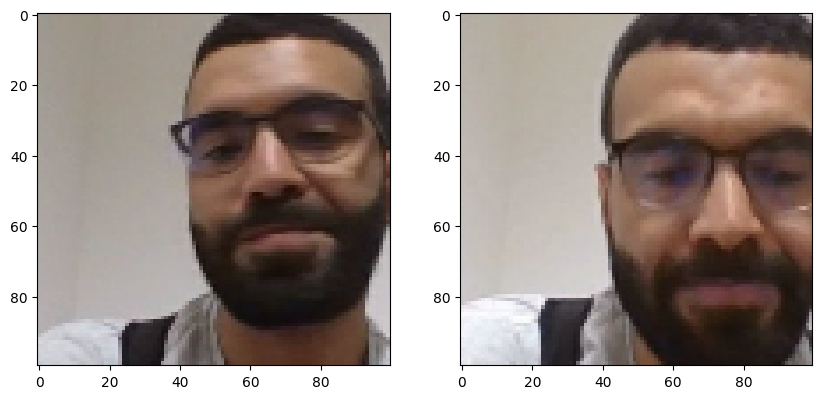

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model


In [ ]:
# Save weights
siamese_model.save('/content/drive/My Drive/side_projects/siamesemodelv2.h5')
L1Dist

__main__.L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('/content/drive/My Drive/side_projects/siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 117ms/step


array([[9.9995840e-01],
       [1.0831876e-08],
       [1.0954865e-06],
       [1.4541343e-05],
       [1.0000000e+00],
       [1.9786103e-06],
       [2.2667038e-08],
       [9.9841690e-01],
       [1.0000000e+00],
       [9.9864084e-01],
       [9.9843878e-01],
       [1.8720780e-10],
       [9.9962103e-01],
       [1.0000000e+00],
       [1.7463060e-06]], dtype=float32)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
!apt-get install git -y
!git config --global user.email "ahmed.mo.0593@gmail.com"
!git config --global user.name "Ahmed-M2020"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
%cd /content/path/to/local/repository

[Errno 2] No such file or directory: '/content/path/to/local/repository'
/content/drive/My Drive/side_projects


In [ ]:
!git clone https://github.com/Ahmed-M2020/side_projects.git

Cloning into 'side_projects'...


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
!git add Facial_Recognition.ipynb

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!git --help

In [ ]:
!git commit -m "Facial_Recognition.ipynb"

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [ ]:
!git init

Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/.git/


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
!git add Facial_Recognition.ipynb

In [ ]:
!git push Facial_Recognition.ipynb

fatal: invalid gitfile format: Facial_Recognition.ipynb
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!git commit -m "Updated file"

[main 8e4a98f] Updated file
 1 file changed, 1 insertion(+), 1 deletion(-)


In [ ]:
!git remote add origin git@github.com:Ahmed-M2020/side_projects.git
!git branch -M main
!git push -u origin main

fatal: remote origin already exists.
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
!git config --global user.name Ahmed-M2020

In [ ]:
!git config --global user.email ahmed.mo.0593@gmail.com

In [ ]:
!git remote -v

origin	git@github.com:Ahmed-M2020/side_projects.git (fetch)
origin	git@github.com:Ahmed-M2020/side_projects.git (push)
